In [1]:
%matplotlib inline


# 4 - Sampling methods: particle filter


In the previous tutorials we encountered some shortcomings in describing distributions as
Gaussians, albeit with considerable flexibility in coping with the non-linear transforms.

Sampling methods offer an attractive alternative to such parametric methods in that there is
no need for complicated though approximate covariance calculations. In this tutorial we look at a
class of *sequential Monte Carlo sampling* methods, and in particular, the *particle filter*.

Colloquially we can think of a particle filter as a series of point samples being recursed
through the predict-update stages of a Bayesian filter. The diversity of samples compensates for
the lack of a covariance estimate, though often at the expense of increased computation
requirements.

## Background

In more detail, we seek to approximate the posterior state estimate as a sum of samples, or
particles,

\begin{align}p(\textbf{x}_{k}|\textbf{z}_{1:k}) \approx
      \sum_{i} w_{k}^i \delta (\textbf{x}_{k} - \textbf{x}_{k}^i)\end{align}

where $w_{k}^i$ are weights such that $\sum\limits_{i} w_{k}^i = 1$. This posterior
can be calculated, and subsequently maintained, by successive applications of the
Chapman-Kolmogorov equation and Bayes rule in an analogous manner to the Kalman family of
filters of previous tutorials. There is considerable flexibility in how to sample from these
various distributions and the interested reader can refer to [#]_ for more detail.

The present tutorial focuses on a so-called *sequential importance resampling* filter. This is
facilitated by a number of Stone Soup classes. The weight-update equation is,

\begin{align}w^i_k = w^i_{k-1}
          \frac{p(\mathbf{z}_k|\mathbf{x}^i_k) p(\mathbf{x}^i_k|\mathbf{x}^1_{k-1})}
               {q(\mathbf{x}^i_k|\mathbf{x}^1_{k-1},\mathbf{z}^i_{1:k})}\end{align}

where $p(\mathbf{z}_k | \mathbf{x}^i_k)$ is the likelihood distribution (as defined by the
:class:`~.MeasurementModel`) and $p(\mathbf{x}^i_k|\mathbf{x}^1_{k-1})$ is the transition
probability distribution (:class:`~.TransitionModel`). The $q(\cdot)$ distribution -- the
importance density -- should approximate the posterior distribution, while still being easy to
sample from.

A common occurrence in such methods is that of *sample impoverishment*. After a few iterations,
all but a small number of the particles will have negligible weight. This affects accuracy and
wastes computation on particles with little effect on the estimate. Many resampling schemes
exist and are designed to redistribute particles to areas where the posterior probability is
higher. In Stone Soup such resampling is accomplished by a :class:`~.Resampler`. More detail is
provided in the
example below.



## Nearly-constant velocity example
We continue in the same vein as the previous tutorials.

### Ground truth
Import the necessary libraries



In [2]:
import numpy as np

from datetime import datetime
from datetime import timedelta
start_time = datetime.now()

In [3]:
np.random.seed(1991)

Initialise Stone Soup ground-truth and transition models.



In [4]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
    ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.05),
                                                          ConstantVelocity(0.05)])
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])

Create the truth path



In [5]:
for k in range(1, 21):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))

Plot the ground truth.



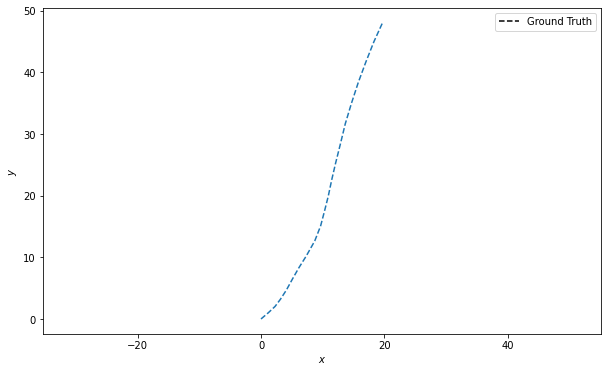

In [6]:
from stonesoup.plotter import Plotter
plotter = Plotter()
plotter.plot_ground_truths(truth, [0, 2])

Initialise the bearing, range sensor using the appropriate measurement model.



In [7]:
from stonesoup.models.measurement.nonlinear import CartesianToBearingRange
from stonesoup.types.detection import Detection

sensor_x = 50
sensor_y = 0

measurement_model = CartesianToBearingRange(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.diag([np.radians(0.2), 1]),
    translation_offset=np.array([[sensor_x], [sensor_y]])
)

Populate the measurement array



In [8]:
measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement, timestamp=state.timestamp,
                                  measurement_model=measurement_model))

Plot those measurements



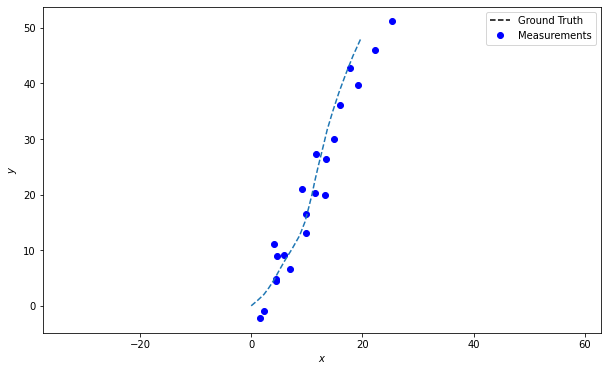

In [9]:
plotter.plot_measurements(measurements, [0, 2])
plotter.fig

### Set up the particle filter
Analogously to the Kalman family, we create a :class:`~.ParticlePredictor` and a
:class:`~.ParticleUpdater` which take responsibility for the predict and update steps
respectively. These require a :class:`~.TransitionModel` and :class:`~.MeasurementModel` as
before.
To cope with sample sparsity we also include a resampler, in this instance
:class:`~.SystematicResampler`, which is passed to the updater. It should be noted that there are
many resampling schemes, and almost as many choices as to when to undertake resampling. The
systematic resampler is described in [#]_, and in what follows below resampling is undertaken
at each time-step.



In [10]:
from stonesoup.predictor.particle import ParticlePredictor
predictor = ParticlePredictor(transition_model)
from stonesoup.resampler.particle import SystematicResampler
resampler = SystematicResampler()
from stonesoup.updater.particle import ParticleUpdater
updater = ParticleUpdater(measurement_model, resampler)

### Initialise a prior
To start we create a prior estimate. This is a set of :class:`~.Particle` and we sample from
Gaussian distribution (using the same parameters we had in the previous examples).



In [11]:
from scipy.stats import multivariate_normal

from stonesoup.types.particle import Particle
from stonesoup.types.numeric import Probability  # Similar to a float type
from stonesoup.types.state import ParticleState

number_particles = 200

# Sample from the prior Gaussian distribution
samples = multivariate_normal.rvs(np.array([0, 1, 0, 1]),
                                  np.diag([1.5, 0.5, 1.5, 0.5]),
                                  size=number_particles)

particles = [
    Particle(sample.reshape(-1, 1), weight=Probability(1/number_particles)) for sample in samples]

# Create prior particle state.
prior = ParticleState(particles, timestamp=start_time)

### Run the tracker
We now run the predict and update steps, propagating the collection of particles and resampling
when told to (at every step).



In [12]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

Plot the resulting track with the sample points at each iteration.



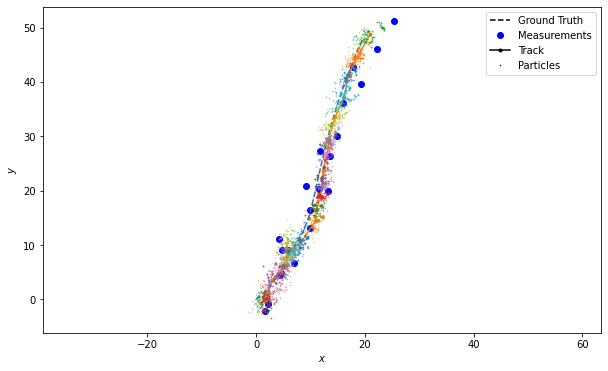

In [13]:
plotter.plot_tracks(track, [0, 2], particle=True)
plotter.fig

## Key points
1. Sampling methods offer an attractive alternative to Kalman-based filtering for recursive
   state estimation.
2. The particle filter trades off a more subtle quantification of a non-Gaussian
   estimate against increased computational effort.
3. Very often particle filters encounter sample impoverishment and require a resampling step.



## References
.. [#] Sanjeev Arulampalam M., Maskell S., Gordon N., Clapp T. 2002, Tutorial on Particle Filters
       for Online Nonlinear/Non-Gaussian Bayesian Tracking,  IEEE transactions on signal
       processing, vol. 50, no. 2

.. [#] Carpenter J., Clifford P., Fearnhead P. 1999, An improved particle filter for non-linear
       problems, IEE Proc., Radar Sonar Navigation, 146:2–7

